In [1]:
import numpy as np
import matplotlib.pyplot as plt
from project_dataload import *
from dscribe.descriptors import CoulombMatrix


# Implementing of gaussian model

In [70]:
class Gaussian_process():

    def __init__(self, x_data, y_data, x_pred, sigma=0.001):
        """
        Input:
            x_data (np.array): NxM matrix of x-values (N rows with a fingerprint, each of M dimensions)
            y_data (np.array): N vector of y-values 
            x_pred (np.array): NxM matrix of x-values to get predicted y values for
        """
        self.x_data = x_data
        self.y_data = y_data
        self.x_pred = x_pred
        self.sigma = sigma
        return None

    ### Defining kernel and kernel matrix
    #Kernel function
    def kernelf(self, x, xprime, l, k0=1):
        """The squared exponential as basis function/kernel"""
        return k0 * np.exp(np.sum(-(x-xprime)**2) / (2 * l**2))

    #Construct the kernel matrix
    def get_kernel_mat(self, l, k0=1):
        """Kernel matrix (covariance matrix) from x_grid and kernel function (using l-param) """
        return np.array([[self.kernelf(x,xprime,l,k0) for x in self.x_data] for xprime in self.x_data])

    #Construct C matrix (sigma has been defined when defining noice)
    def get_c_mat(self, K):
        """C matrix from sigma and K"""
        N = np.shape(K)[0] #K is symmetric, dimension is num of datapoints
        return K + self.sigma**2 * np.identity(N)

    #construct k vector
    def get_k_vec(self, x, l, k0=1):
        """K vector for given x, given x-val of data and l-param"""
        return np.array([self.kernelf(x, xprime, l, k0) for xprime in self.x_data])

    #Construct the prior average function (here just a constant)
    def get_yprior_av(self, xval, param1):
        """Defining a constant function as the prior average function"""
        return param1

    ###Functions for predictions
    def get_predictions(self, l, k0=1, cst_av=0):
        """Function to predict y-values by a gaussian process from an array of x-values
        
        Input: 
            l, sigma, k0 (floats): hyper parameters
            cst_av (float): average of data
        """
        N_data = len(self.x_data)
    
        #Elements only needed to be calculated once (C^(-1).(t-y_av_prior))
        K_mat = self.get_kernel_mat(l,k0)
        C_mat = self.get_c_mat(K_mat)
        yprior_av = self.get_yprior_av(0, cst_av)
        yprior_av_vec = np.ones(N_data) * yprior_av
        t_ypriorav_vec = self.y_data - yprior_av_vec
        #Solving inversion x=C^(-1).(y_data-y_av_prior) without inverting matrix (costly)
        C_inv_t = np.linalg.solve(C_mat, t_ypriorav_vec)
        print(f'in get_predictions(): calculated C_inv_t ...')

        #Make prediction for each x input
        y_predictions = []
        for i,x_val in enumerate(self.x_pred):
            k_vec = self.get_k_vec(x_val,l,k0)
            y_pred = yprior_av + k_vec.transpose() @ C_inv_t
            y_predictions.append(y_pred)
            
            if i % 10 == 0:
                print(f'in get_predictions(): Predicted {i} vals ...')
        
        return np.array(y_predictions)

    def get_variances(self, l, k0=1):
        
        K_mat = self.get_kernel_mat(l,k0)
        C_mat = self.get_c_mat(K_mat)
        C_mat_inv = np.linalg.inv(C_mat)
        
        #Make variance for each x input
        y_variances = []
        for x_val in self.x_pred:
            k_vec = self.get_k_vec(x_val,l,k0)
            kernel_val = self.kernelf(x_val,x_val,l,k0)
            y_variance = kernel_val - k_vec.transpose() @ C_mat_inv @ k_vec
            
            y_variances.append(y_variance)
        
        return np.array(y_variances)



IndentationError: unindent does not match any outer indentation level (<tokenize>, line 9)

In [13]:
data_dir="./project_data/"

train, test = data_load(data_dir)

check_data(train)
summary = summarize_1(train,test)
print(summary['max_number_of_atoms'])

Train data shape: (8000, 4)
     id        formula                                              atoms  \
0  5154         Zr2BO2  (Atom('Zr', [1.6878604657, 0.892285133, 8.1345...   
1   984          Ni2S6  (Atom('Ni', [1.1571403137, 0.934725185, 12.234...   
2  1634  Cd4K2Cl6O6Te2  (Atom('Cd', [2.7840261751, 5.6922402759, 26.71...   
3  1872      Hf4H2N3O2  (Atom('Hf', [0.0, 1.8677827772, 12.2421466347]...   
4  2977         Sc2Te2  (Atom('Te', [0.0003850118, 0.0002469812, 7.461...   

      hform  
0 -2.037877  
1 -0.091020  
2 -1.109751  
3 -1.609142  
4 -0.854593  
20


In [14]:
# Setting up the CM descriptor
n_atoms_max = summary['max_number_of_atoms']
cm = CoulombMatrix(
    n_atoms_max=n_atoms_max,
)

cmats_train = np.zeros((len(train),n_atoms_max**2))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmats_train[i,:] = cm.create(atoms)
print(len(cmats_train))
print(np.shape(cmats_train))


cmats_test = np.zeros((len(test),n_atoms_max**2))
for i,atoms in enumerate(test.atoms):
    if i%1000 == 0:
        print(i)
    cmats_test[i,:] = cm.create(atoms)
print(len(cmats_test))
print(np.shape(cmats_test))

0
1000
2000
3000
4000
5000
6000
7000
8000
(8000, 400)
0
1000
2000
3000
4000
(4000, 400)


(1000, 400)
(1000,)
(100, 400)
(100,)
                 id        hform
count   8000.000000  8000.000000
mean    7903.234875    -0.622866
std     4560.292278     0.672705
min        1.000000    -4.016701
25%     4020.750000    -0.981515
50%     7945.000000    -0.474902
75%    11855.500000    -0.160427
max    15732.000000     1.767721


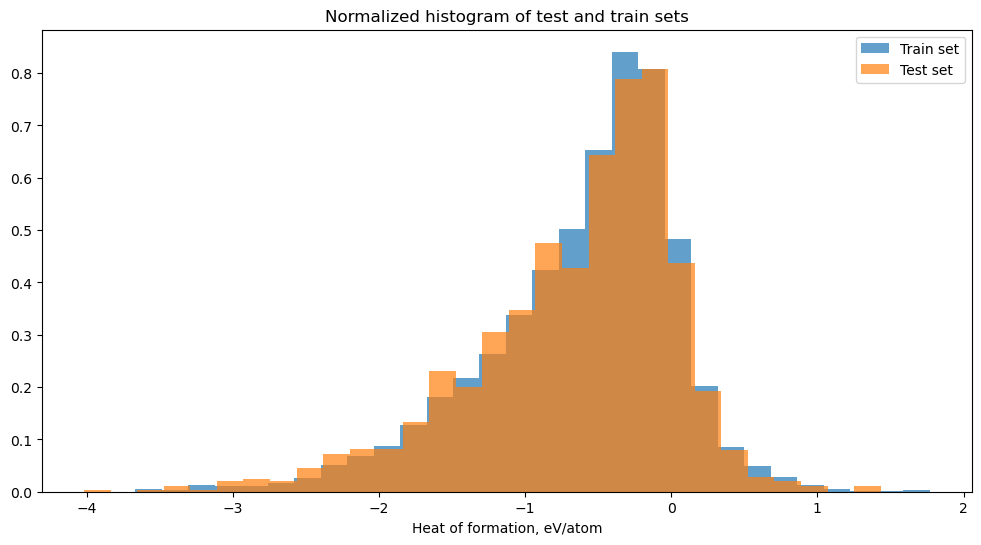

In [57]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(data = cmats_train, index=train.id)
y = train['hform']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=251)

nt = 1000
ntest = 100

X_train_lim = np.copy(X_train[:nt])
y_train_lim = np.copy(y_train[:nt])
X_test_lim = np.copy(X_test[:ntest])
y_test_lim = np.copy(y_test[:ntest])


print(X_train_lim.shape)
print(y_train_lim.shape)
print(X_test_lim.shape)
print(y_test_lim.shape)
print(train.describe())

plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Heat of formation, eV/atom")
plt.legend()
plt.show()

In [66]:
sigma = 0.01
k0 = 1
l = 100

In [67]:
GP1 = Gaussian_process(X_train_lim,y_train_lim,X_test_lim,sigma=sigma)

y_pred = GP1.get_predictions(l=l, k0=k0, cst_av=-0.623)

in get_predictions(): calculated C_inv_t ...
in get_predictions(): Predicted 0 vals ...
in get_predictions(): Predicted 10 vals ...
in get_predictions(): Predicted 20 vals ...
in get_predictions(): Predicted 30 vals ...
in get_predictions(): Predicted 40 vals ...
in get_predictions(): Predicted 50 vals ...
in get_predictions(): Predicted 60 vals ...
in get_predictions(): Predicted 70 vals ...
in get_predictions(): Predicted 80 vals ...
in get_predictions(): Predicted 90 vals ...


Text(0, 0.5, 'Model prediction of heat of formation')

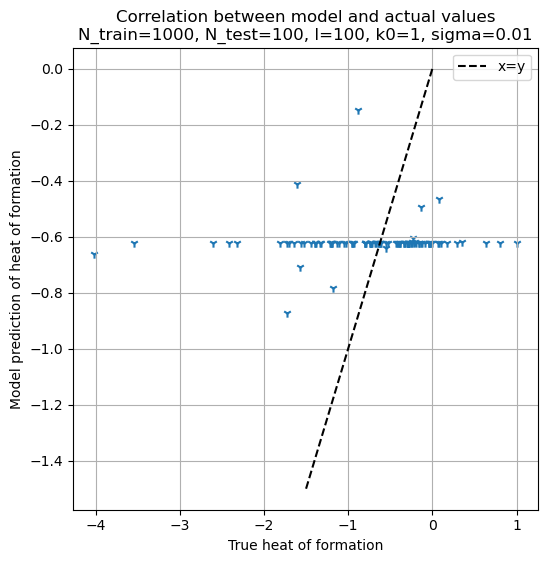

In [68]:
###Plotting
xg = np.linspace(-1.5,0,10)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_test_lim, y_pred, marker='1')
ax.plot(xg,xg, color='black', linestyle='dashed', label='x=y')
ax.legend()
ax.grid()
#ax.set_title(f'Correlation between model and actual values\nN_train={nt}, N_test={ntest}')
ax.set_title(f'Correlation between model and actual values\nN_train={nt}, N_test={ntest}, l={l}, k0={k0}, sigma={sigma}')
ax.set_xlabel('True heat of formation')
ax.set_ylabel('Model prediction of heat of formation')
